<a href="https://colab.research.google.com/github/nagelex/dataa/blob/main/Classes_08_model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model selection: in a search for the best model

In this notebook you will learn various techniques to help you in the model selection procedure:
- [Cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/) procedure used to evaluate machine learning models on a limited data sample.
- [Grid search](https://medium.com/fintechexplained/what-is-grid-search-c01fe886ef0a) used to find the optimal hyperparameters of a model which results in the most ‘accurate’ predictions.
- Statistical tests for comparing models' performance.

---
**Let's find the best model of *Orthodoxy ~ Extraversion+ Agreeableness + Conscientiousness + Openness + Neuroticism***

Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

import io
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error

from scipy import stats

import warnings

warnings.filterwarnings("ignore")

In [ ]:
# parameters for plotting
plt.rcParams["figure.figsize"] = (10,7)

In [ ]:
# constants
test_size=0.2
random_state=42

In [ ]:
def compute_score(y_true, y_pred):
  '''
  Helper function for printing scores.

  Parameters:
  y_true: ndarray of y values from original dataset.
  y_pred: ndarray of y values predicted with given model.

  Return:
  dictionary object that consists of R2 and median absolute error scores.

  '''
  return {
        "R2": r2_score(y_true, y_pred),
        "MedianAE": median_absolute_error(y_true, y_pred),
}

## Load dataset

In [ ]:
df = pd.read_csv('data_neo-ffi_religion (1).csv')
df['Orthodoxy'] = np.log(df[['Orthodoxy']].to_numpy())
df.head()

,Extraversion,Agreeableness,Conscientiousness,Openness,Neuroticism,External Critique,Orthodoxy,Historical Relativism,Relativism,Second Naïveté
0,34.082439,46.043690,40.788554,461.110426,43.865868,2.838143,2.586507,3.744990,6.093860,4.458938
1,45.914894,45.968433,41.235290,401.384274,28.027017,3.824136,2.294873,3.392507,5.230517,3.269949
2,33.008654,42.065841,42.069170,390.193510,41.023889,2.288471,2.367948,3.765416,4.801786,4.683288
3,56.112153,45.903571,53.080369,468.518727,20.018578,5.824989,2.621076,2.826005,2.592473,0.883451
4,31.972346,49.009174,42.161417,508.686847,43.026028,4.038579,2.736421,4.689029,4.916692,4.627536


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Prepare data

Inspect the dataset

In [ ]:
df.describe()

,Extraversion,Agreeableness,Conscientiousness,Openness,Neuroticism,External Critique,Orthodoxy,Historical Relativism,Relativism,Second Naïveté
count,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000
mean,37.811238,42.318673,41.208357,436.675828,36.042290,3.880765,2.581919,4.883313,5.299550,4.223002
std,8.871624,7.222606,8.104708,63.642560,11.014191,1.259730,1.129017,0.778776,0.944093,1.392345
min,14.040682,21.008399,16.904128,289.257541,12.942666,0.876634,0.816596,1.304512,1.905408,0.801310
25%,32.079634,37.959417,35.084398,388.849925,27.908735,3.046971,1.706643,4.430331,4.729321,3.169300
50%,38.954182,43.089033,41.052187,440.203497,35.908038,3.762668,2.411769,4.922857,5.437686,4.434408
75%,43.946449,47.078293,47.089308,480.501705,44.692161,4.684792,3.334454,5.373428,5.981834,5.213640
max,56.882820,59.121317,59.000430,572.957659,60.030339,6.935906,7.131491,6.877499,7.139185,7.151545


Create classes

In [ ]:
df['class'] = df[['External Critique', 'Orthodoxy', 'Relativism', 'Second Naïveté']].idxmax(axis=1)

In [ ]:
df.head()

,Extraversion,Agreeableness,Conscientiousness,Openness,Neuroticism,External Critique,Orthodoxy,Historical Relativism,Relativism,Second Naïveté,class
0,34.082439,46.043690,40.788554,461.110426,43.865868,2.838143,2.586507,3.744990,6.093860,4.458938,Relativism
1,45.914894,45.968433,41.235290,401.384274,28.027017,3.824136,2.294873,3.392507,5.230517,3.269949,Relativism
2,33.008654,42.065841,42.069170,390.193510,41.023889,2.288471,2.367948,3.765416,4.801786,4.683288,Relativism
3,56.112153,45.903571,53.080369,468.518727,20.018578,5.824989,2.621076,2.826005,2.592473,0.883451,External Critique
4,31.972346,49.009174,42.161417,508.686847,43.026028,4.038579,2.736421,4.689029,4.916692,4.627536,Relativism


Select X and y sets

In [ ]:
X = df[[
    'Extraversion',
    'Agreeableness',
    'Conscientiousness',
    'Openness',
    'Neuroticism'
    ]]

y = df[['Orthodoxy']]

Train-test split

In [ ]:
# to ensure repeatability of splits, we set the random state
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=test_size,
    random_state=random_state
)

print(f"Shape of the X train dataset: {X_train.shape}")
print(f"Shape of the X test dataset: {X_test.shape}")
print(f"Shape of the y train dataset: {y_train.shape}")
print(f"Shape of the y test dataset: {y_test.shape}")

Shape of the X train dataset: (273, 5)
Shape of the X test dataset: (69, 5)
Shape of the y train dataset: (273, 1)
Shape of the y test dataset: (69, 1)


---
## Best model: Problem 1 - Choosing

It is quite obvious that we would like to find the best model of *Orthodoxy vs Big Five*. As we saw during the last classes for e.g., SVM we can set the values at least two hyperparameters - and there is a lot of values to test! What model - what hyperparameters - are the best?

**And what does it mean - *\"the best model\"*?**

As everywhere, we have to have a metric that says what is better. Until now, when we said *\"the best model\"*, we were comparing the results on a **test set**. But the test set should not be used for comparison.

What is the test set for?

We should use the test set only for the final evaluation of the best model. Otherwise, there is a leakage of knowledge from the test set - it is used to choose the best model (i.e. fit!) not for pure evaluation.

So - we have to choose the best model to and **then** perform a final testing. Let's try to do this!

### Exercise 1. Comparing models based on the training dataset

Create a list of kernels to test and C to test (and epsilons to test) and using for loops try to find the best SVM model.Use only **training set** to choose the best SVM model.

In [ ]:
# your code
C_list = [0.0001, 0.1, 1.0, 10000]
epsilon_list = [0.1, 1, 2]
kernel_list = ['linear', 'rbf']

fresults = pd.DataFrame()
for C in C_list:
  for epsilon in epsilon_list:
    for kernel in kernel_list:
      estimator = SVR(C=C, epsilon=epsilon, kernel=kernel)
      svm = make_pipeline(StandardScaler(), estimator)
      svm.fit (X_train, y_train.to_numpy().ravel()) #Return a contiguous flattened array
      y_train_pred = svm.predict(X_train)
      r2 = compute_score(y_train, y_train_pred)["R2"]

      results = pd.DataFrame({
          "C": [C],
          "epsilon": [epsilon],
          "kernel": [kernel],
          "R2": [r2],
          "model": [svm]
          })
      fresults = pd.concat([results, fresults], ignore_index = True)

results_df = fresults.copy()

best_result = results_df.loc[results_df['R2'].idxmax()]

print("Best Hyperparameters:")
print("C:", best_result['C'])
print("epsilon:", best_result['epsilon'])
print("kernel:", best_result['kernel'])
print("Best R2 Score:", best_result['R2'])


Best Hyperparameters:
C: 10000.0
epsilon: 0.1
kernel: rbf
Best R2 Score: 0.9928550152586747


In [ ]:
results_df

,C,epsilon,kernel,R2,model
0,10000.0000,2.0,rbf,-0.135967,"(StandardScaler(), SVR(C=10000, epsilon=2))"
1,10000.0000,2.0,linear,0.022707,"(StandardScaler(), SVR(C=10000, epsilon=2, ker..."
2,10000.0000,1.0,rbf,0.505552,"(StandardScaler(), SVR(C=10000, epsilon=1))"
3,10000.0000,1.0,linear,0.166303,"(StandardScaler(), SVR(C=10000, epsilon=1, ker..."
4,10000.0000,0.1,rbf,0.992855,"(StandardScaler(), SVR(C=10000))"
5,10000.0000,0.1,linear,0.157485,"(StandardScaler(), SVR(C=10000, kernel='linear'))"
6,1.0000,2.0,rbf,-0.130165,"(StandardScaler(), SVR(epsilon=2))"
7,1.0000,2.0,linear,-0.015978,"(StandardScaler(), SVR(epsilon=2, kernel='line..."
8,1.0000,1.0,rbf,0.327585,"(StandardScaler(), SVR(epsilon=1))"
9,1.0000,1.0,linear,0.166678,"(StandardScaler(), SVR(epsilon=1, kernel='line..."


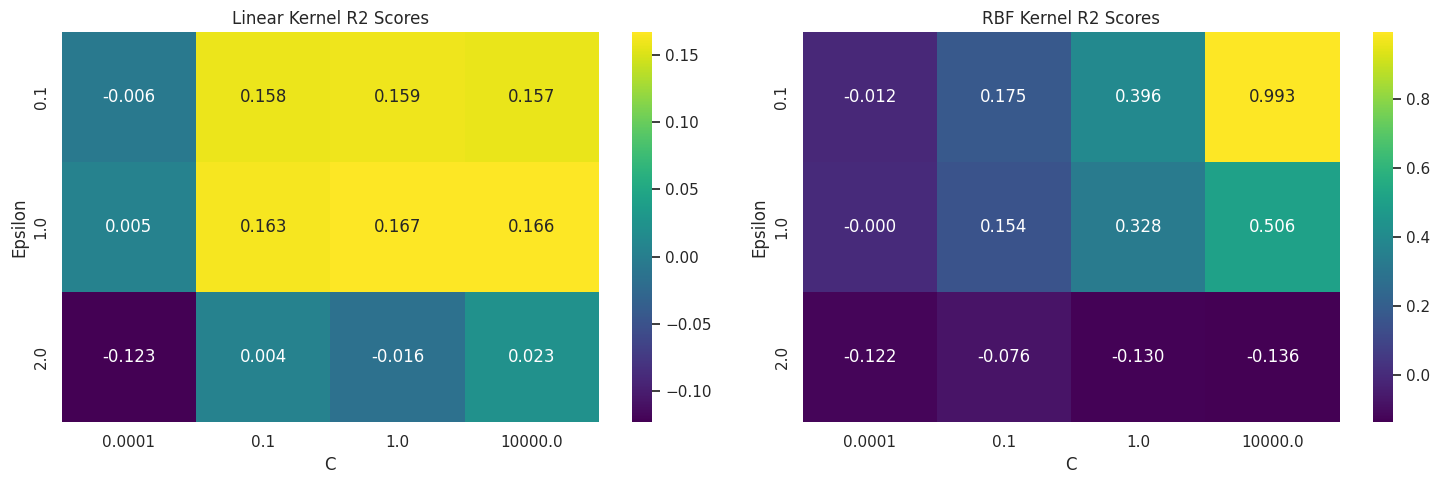

In [ ]:
import seaborn as sns

# Assuming results_df is already defined

# Separate results for each kernel
linear_results = results_df[results_df['kernel'] == 'linear']
rbf_results = results_df[results_df['kernel'] == 'rbf']

# Create heatmaps for R2 scores
plt.figure(figsize=(15, 5))

# Linear Kernel Heatmap
plt.subplot(1, 2, 1)
linear_heatmap_data = linear_results.pivot('epsilon', 'C', 'R2')
sns.heatmap(linear_heatmap_data, annot=True, cmap='viridis', fmt='.3f', cbar=True)
plt.title('Linear Kernel R2 Scores')
plt.xlabel('C')
plt.ylabel('Epsilon')

# RBF Kernel Heatmap
plt.subplot(1, 2, 2)
rbf_heatmap_data = rbf_results.pivot('epsilon', 'C', 'R2')
sns.heatmap(rbf_heatmap_data, annot=True, cmap='viridis', fmt='.3f', cbar=True)
plt.title('RBF Kernel R2 Scores')
plt.xlabel('C')
plt.ylabel('Epsilon')

plt.tight_layout()
plt.show()

Which model is the best?

Let's check the validation (test) scores of models and check if we were right.

In [ ]:
results_test_df = results_df.copy()

# create an empty column for r2 score on test set
results_test_df['test_r2_score'] = 0

for idx, row in results_df.iterrows():
  # get model form dataframe
  model = row['model']

  # evaluate model on the test set
  y_test_pred = model.predict(X_test)
  r2 = compute_score(y_test, y_test_pred)['R2']

  # save results to dataframe
  results_test_df.at[idx, 'test_r2_score'] = r2

display(results_test_df)

,C,epsilon,kernel,R2,model,test_r2_score
0,10000.0000,2.0,rbf,-0.135967,"(StandardScaler(), SVR(C=10000, epsilon=2))",-0.241565
1,10000.0000,2.0,linear,0.022707,"(StandardScaler(), SVR(C=10000, epsilon=2, ker...",0.113877
2,10000.0000,1.0,rbf,0.505552,"(StandardScaler(), SVR(C=10000, epsilon=1))",0.455682
3,10000.0000,1.0,linear,0.166303,"(StandardScaler(), SVR(C=10000, epsilon=1, ker...",0.250597
4,10000.0000,0.1,rbf,0.992855,"(StandardScaler(), SVR(C=10000))",-0.589140
5,10000.0000,0.1,linear,0.157485,"(StandardScaler(), SVR(C=10000, kernel='linear'))",0.267702
6,1.0000,2.0,rbf,-0.130165,"(StandardScaler(), SVR(epsilon=2))",-0.230468
7,1.0000,2.0,linear,-0.015978,"(StandardScaler(), SVR(epsilon=2, kernel='line...",0.047439
8,1.0000,1.0,rbf,0.327585,"(StandardScaler(), SVR(epsilon=1))",0.255151
9,1.0000,1.0,linear,0.166678,"(StandardScaler(), SVR(epsilon=1, kernel='line...",0.252106


It is clear that some models are overfitted.


**Obviously, given the phenomenon of overfitting, the model with the best score on the training set is not the model with the best score on the test set!!!**

Cross-validation provides better estimates of the real prodictive performance of tested models.

### Exercise 2. Cross-validation
See the documentation of calculating the cross-validated scores in scikit-learn: [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) and then:
1. Add estimation of the cross-validated scores to the code below.
2. Add the mean CV score to the dataframe with the results.

In [ ]:
C_list = [0.0001, 0.1, 1.0, 10000]
epsilon_list = [0.1, 1, 2]
kernel_list = ['linear', 'rbf']

results_cv_df = pd.DataFrame()

for C in C_list:
  for epsilon in epsilon_list:
    for kernel in kernel_list:
      estimator = SVR(C=C, epsilon=epsilon, kernel=kernel)

      # create pipeline
      model = make_pipeline(StandardScaler(), estimator)

      # fit model
      model.fit(X_train, y_train.to_numpy().ravel())

      # predict on the training data
      y_train_pred = model.predict(X_train)
      r2 = compute_score(y_train, y_train_pred)['R2']

      # compute cross validated r2 scores on train data
      k_folds = 3
      cv_scores = cross_val_score(model, X_train, y_train, cv= k_folds)
      mean_cv_score = np.mean(cv_scores)

      # define model name
      model_name = f"kernel: {kernel}, C:{C}, epsilon: {epsilon}"

      # save results in dataframe
      this_result = pd.DataFrame({
          "model_name": [model_name],
          "train_r2_score": [r2],
          'cv_r2_score': [mean_cv_score],
          "model": [model],
      })

      results_cv_df = pd.concat([results_cv_df, this_result], ignore_index=True)

In [ ]:
results_cv_df

,model_name,train_r2_score,cv_r2_score,model
0,"kernel: linear, C:0.0001, epsilon: 0.1",-0.005651,-0.011154,"(StandardScaler(), SVR(C=0.0001, kernel='linea..."
1,"kernel: rbf, C:0.0001, epsilon: 0.1",-0.012077,-0.014483,"(StandardScaler(), SVR(C=0.0001))"
2,"kernel: linear, C:0.0001, epsilon: 1",0.004619,-0.003506,"(StandardScaler(), SVR(C=0.0001, epsilon=1, ke..."
3,"kernel: rbf, C:0.0001, epsilon: 1",-0.000309,-0.006158,"(StandardScaler(), SVR(C=0.0001, epsilon=1))"
4,"kernel: linear, C:0.0001, epsilon: 2",-0.123210,-0.123092,"(StandardScaler(), SVR(C=0.0001, epsilon=2, ke..."
5,"kernel: rbf, C:0.0001, epsilon: 2",-0.121876,-0.122341,"(StandardScaler(), SVR(C=0.0001, epsilon=2))"
6,"kernel: linear, C:0.1, epsilon: 0.1",0.157802,0.110517,"(StandardScaler(), SVR(C=0.1, kernel='linear'))"
7,"kernel: rbf, C:0.1, epsilon: 0.1",0.174930,0.079728,"(StandardScaler(), SVR(C=0.1))"
8,"kernel: linear, C:0.1, epsilon: 1",0.162754,0.109005,"(StandardScaler(), SVR(C=0.1, epsilon=1, kerne..."
9,"kernel: rbf, C:0.1, epsilon: 1",0.154113,0.081419,"(StandardScaler(), SVR(C=0.1, epsilon=1))"


Which model is the best?

Let's check the validation (test) scores of models.

In [ ]:
results_cv_test_df = results_cv_df.copy()

# create an empty column for r2 score on test set
results_cv_test_df['test_r2_score'] = 0

for idx, row in results_cv_df.iterrows():
  # get model form dataframe
  model = row['model']

  # evaluate model on the test set
  y_test_pred = model.predict(X_test)
  r2 = compute_score(y_test, y_test_pred)['R2']

  # save results to dataframe
  results_cv_test_df.at[idx, 'test_r2_score'] = r2

display(results_cv_test_df)

,model_name,train_r2_score,cv_r2_score,model,test_r2_score
0,"kernel: linear, C:0.0001, epsilon: 0.1",-0.005651,-0.011154,"(StandardScaler(), SVR(C=0.0001, kernel='linea...",0.009821
1,"kernel: rbf, C:0.0001, epsilon: 0.1",-0.012077,-0.014483,"(StandardScaler(), SVR(C=0.0001))",0.000502
2,"kernel: linear, C:0.0001, epsilon: 1",0.004619,-0.003506,"(StandardScaler(), SVR(C=0.0001, epsilon=1, ke...",-0.012513
3,"kernel: rbf, C:0.0001, epsilon: 1",-0.000309,-0.006158,"(StandardScaler(), SVR(C=0.0001, epsilon=1))",-0.019453
4,"kernel: linear, C:0.0001, epsilon: 2",-0.123210,-0.123092,"(StandardScaler(), SVR(C=0.0001, epsilon=2, ke...",-0.201596
5,"kernel: rbf, C:0.0001, epsilon: 2",-0.121876,-0.122341,"(StandardScaler(), SVR(C=0.0001, epsilon=2))",-0.200123
6,"kernel: linear, C:0.1, epsilon: 0.1",0.157802,0.110517,"(StandardScaler(), SVR(C=0.1, kernel='linear'))",0.260955
7,"kernel: rbf, C:0.1, epsilon: 0.1",0.174930,0.079728,"(StandardScaler(), SVR(C=0.1))",0.176470
8,"kernel: linear, C:0.1, epsilon: 1",0.162754,0.109005,"(StandardScaler(), SVR(C=0.1, epsilon=1, kerne...",0.235246
9,"kernel: rbf, C:0.1, epsilon: 1",0.154113,0.081419,"(StandardScaler(), SVR(C=0.1, epsilon=1))",0.152200


Take a look at $R^2$ *~ models* plot. You can see that CV scores more or less follow test scores, **especially for the overfitting case**.

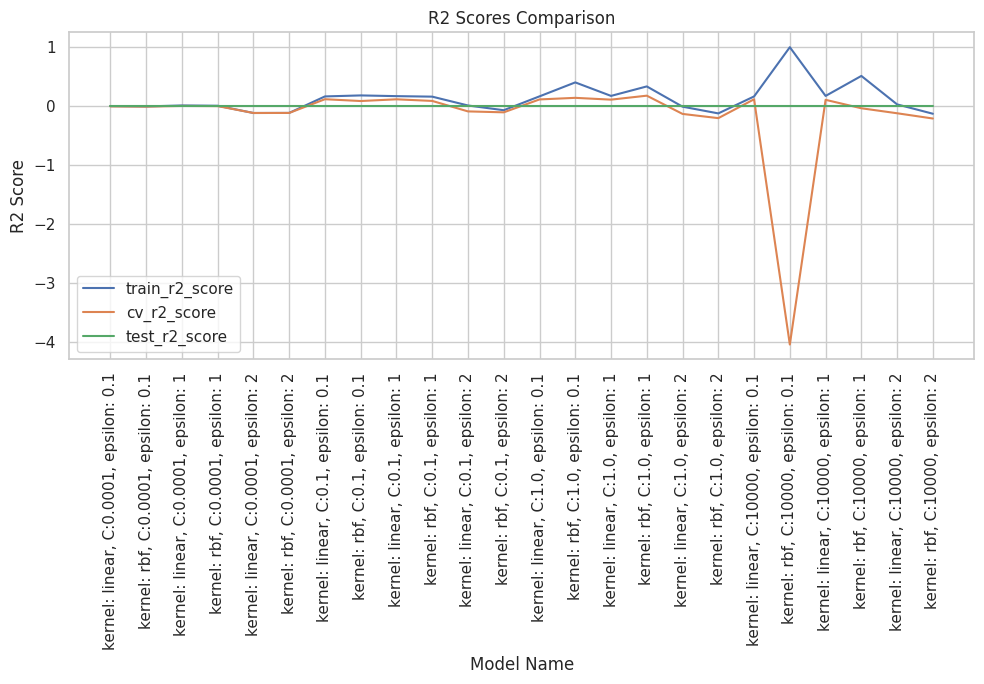

In [ ]:
df_melted = pd.melt(results_cv_test_df, id_vars=['model_name'], value_vars=['train_r2_score', 'cv_r2_score', 'test_r2_score'])

sns.lineplot(df_melted, y='value', x='model_name', hue='variable')

# Customize the plot
plt.title('R2 Scores Comparison')
plt.xlabel('Model Name')
plt.ylabel('R2 Score')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()

Now we see that with cross-validation we better choose our best model. CV score is much more reliable than a simple test score. This is very important especially when comparing different models before final testing.
- **Relying only on the train score can lead to an overestimation of the model's performance and predictive power.**
- **Relying on the test score lead to knowledge leaking and loss of generalisability.**

### (Exercise 2.1) Compare mean CV scores for different number of folds

Models fit always depends on the dataset (as you remember from one of the homeworks). The more folds, the larger the set the model fits on, but the smaller the set for internal testing. Test whether (and how) the number of folds, and therefore the size of the internal sets for training and testing, affects the quality of the model. Compare the results to the r2 of the training and testing set.

In [ ]:
# your code

In [ ]:
# your plotting code

---
## Best model: Problem 2 - Searching and choosing

Using the SVR example, we saw that in certain estimators we can set certain parameters that change the way the data is fit. These parameters are called **hyperparameters** of the model.

It is intuitive, that there is an optimal composition of hyperparameters that yield the best score. It is quite hard to find optimal hyperparameters for an estimator, considering how huge a space we have to search.

Finding optimal hyperparameters is an optimization problem - and there are some techniques that help us to search over specified hyperparameters values for an estimator.

One of such techniques is so called [`Grid Search`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). `Grid Search` performs exhaustive search over specified parameter values for an estimator.

Let's try to use `GridSearch` to find optimal hyperparameters values for estimators.

- `GridSearch` works exactly the same as `Pipelines` - we can `fit()` and `predict()` on `GridSearch` object.
- `GridSearch` is parametrised with so called `param_grid` - the dictionary of parameters, where keys are estimator's parameters (hyperparameters) and values are lists of huperparameters' values to test, e.g.:

```
svr_params = dict(
    svr__kernel=["rbf"],
    svr__C=[1, 10],
    svr__epsilon=[2, 5, 10],
)
```
- You can pass `scoring` parameter to `GridSearch`, to set the metric of performance evaluation, e.g., `scoring = "r2"`.
- You can pass the strategy of CV splitting, or just the number of folds, e.g., `cv=5`.



### Exercise 3: Serch for SVR best hyperparameters

In [ ]:
svr_params =  Pipeline(steps =[('scaler', StandardScaler(), ('svr', SVR()))])

In [ ]:
svs_params = dict(
    svr__C= [0.01, 1, 100, 10000],
    svr__kernel = ["rbf", 'linear'],
    svr__epsilon=[0.1, 1, 10]
    )

In [ ]:
# create pipeline
model = make_pipeline(StandardScaler(), SVR())

# define cross-validation k
cv_kf = k_folds

# define grid search
grid_search_model = GridSearchCV(
    model, svs_params, scoring = 'r2', cv = cv_kf
)
# fit model
grid_search_model.fit(X_train, y_train)

# predict on test data
y_test_pred = grid_search_model.predict(X_test)
test_score = r2_score(y_test, y_test_pred)
print(f'Test R2 score: {test_score}')

# predict on train data
y_train_pred = grid_search_model.predict(X_train)
train_score = r2_score(y_train, y_train_pred)
print(f'Train R2 score: {train_score}')

# extract mean cv scores
mean_cv_score = grid_search_model.best_score_
print(f'CV mean R2 score: {mean_cv_score}')

Test R2 score: 0.2551511137710343
Train R2 score: 0.32758475274614784
CV mean R2 score: 0.1706053903524658


View results of Grid Search:

In [ ]:
print(f"Choosen model: {grid_search_model.best_estimator_}\n")
print(f"Choosen hyperparameters: {grid_search_model.best_params_}\n")
print(f"Train score: {train_score} \nTest score: {test_score}")

Choosen model: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=1, epsilon=1))])

Choosen hyperparameters: {'svr__C': 1, 'svr__epsilon': 1, 'svr__kernel': 'rbf'}

Train score: 0.32758475274614784 
Test score: 0.2551511137710343


Look at the Grid Search results in details:

In [ ]:
cv_results_df = pd.DataFrame(grid_search_model.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svr__C,param_svr__epsilon,param_svr__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007703,0.002185,0.003234,0.000111,0.01,0.1,rbf,"{'svr__C': 0.01, 'svr__epsilon': 0.1, 'svr__ke...",0.011557,-0.013841,0.020144,0.005953,0.014429,12
1,0.006046,0.000449,0.002773,0.000085,0.01,0.1,linear,"{'svr__C': 0.01, 'svr__epsilon': 0.1, 'svr__ke...",0.148326,-0.021531,0.144938,0.090578,0.079285,9
2,0.005333,0.000069,0.002682,0.000016,0.01,1,rbf,"{'svr__C': 0.01, 'svr__epsilon': 1, 'svr__kern...",0.012272,0.005993,0.008783,0.009016,0.002569,11
3,0.005099,0.000311,0.002520,0.000031,0.01,1,linear,"{'svr__C': 0.01, 'svr__epsilon': 1, 'svr__kern...",0.102270,0.030332,0.134897,0.089166,0.043683,10
4,0.005037,0.000778,0.002619,0.000391,0.01,10,rbf,"{'svr__C': 0.01, 'svr__epsilon': 10, 'svr__ker...",-0.487023,-1.505508,-1.731418,-1.241316,0.541281,16
5,0.004414,0.000022,0.002357,0.000020,0.01,10,linear,"{'svr__C': 0.01, 'svr__epsilon': 10, 'svr__ker...",-0.487023,-1.505508,-1.731418,-1.241316,0.541281,16
6,0.006651,0.000151,0.003388,0.000094,1,0.1,rbf,"{'svr__C': 1, 'svr__epsilon': 0.1, 'svr__kerne...",0.170427,-0.031240,0.262224,0.133804,0.122573,2
7,0.008732,0.001483,0.003512,0.000662,1,0.1,linear,"{'svr__C': 1, 'svr__epsilon': 0.1, 'svr__kerne...",0.195332,-0.100030,0.225315,0.106872,0.146813,5
8,0.007355,0.001444,0.003556,0.000304,1,1,rbf,"{'svr__C': 1, 'svr__epsilon': 1, 'svr__kernel'...",0.189063,0.111092,0.211661,0.170605,0.043082,1
9,0.007574,0.001165,0.002839,0.000173,1,1,linear,"{'svr__C': 1, 'svr__epsilon': 1, 'svr__kernel'...",0.139116,-0.018767,0.189354,0.103234,0.088672,6


---
### (Exercise 3.1) Potting GS results
Try to plot results of the grid search to see how the values of the given hyperparameters affected the performance of the model. Plot e.g., $R^2$ *~ epsilon*, with hue on C values.

In [ ]:
df_melted = pd.meltcv_results_df, id_vars=['params'], value_vars=['train_r2_score', 'cv_r2_score', 'test_r2_score'])

sns.lineplot(df_melted, y='value', x='model_name', hue='variable')

# Customize the plot
plt.title('R2 Scores Comparison')
plt.xlabel('Model Name')
plt.ylabel('R2 Score')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.tight_layout()

---

In [ ]:
cv_results_df.iloc[[grid_search_model.best_index_]]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svr__C,param_svr__epsilon,param_svr__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,0.008205,0.000147,0.004047,0.000044,1,1,rbf,"{'svr__C': 1, 'svr__epsilon': 1, 'svr__kernel'...",0.189063,0.111092,0.211661,0.170605,0.043082,1


In [ ]:
cv_splits_scores = cv_results_df.filter(
    regex=r"split\d*_test_r2").iloc[grid_search_model.best_index_]

In [ ]:
print(f"Best estimator: {grid_search_model.best_estimator_}\n")
print(f"Best parameters: {grid_search_model.best_params_}\n")
print(f"Best mean CV score: {grid_search_model.best_score_}\n")
print(f"CV scores:\n{cv_splits_scores}")

Best estimator: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=1, epsilon=1))])

Best parameters: {'svr__C': 1, 'svr__epsilon': 1, 'svr__kernel': 'rbf'}

Best mean CV score: 0.1706053903524658

CV scores:
Series([], Name: 8, dtype: float64)


**Now we know the values of hyperparameters of the model with the best mean CV score. And - most importantly - we have chosen our model without knowledge leakage for the testing set.**